# AI Community @ Семинар № 8, весна 2018
## Style transfer.

Обратимся к предыдущей тетрадке. В ней мы пытались восстановить текстуру из данного распредления. При этом мы пользовались ошибкой $L = \sum_l w_{style,l} E_{style, l}$. Изменим задачу. Нам так же дают текстуру, но еще добавляют другое изображение $O$. Наша цель перенести стиль изображения-текстуры на изображение О.

Пример:
<img src='images/starry_night_transfer.png'>
<div style="text-align: right"><font size="2">Изображение из статьи [1]</font></div>

Так же изменим функцию ошибки, а именно добавим часть, которая будут отвечать за оригинал изображения:
$$E_{content,k} = w_{content} \sum_{i,j} (F_{content}^k - F_{gen}^k)^2\,\,\,\,\,(1)$$, где $F_{content}^k$ - сохраненная карта признаков оригинального изображения $O$ на слое $k$, $F_{gen}^k$ - карта признаков генерируемого изображения на слое $k$, $w_{content}$ - вес изображения $O$ в финальном лоссе. Тогда:
$$L = (\sum_l w_{style,l} E_{style, l}) + E_{content,k}$$, где $k$ - номер слоя из которого будет извлекаться представление изображения $O$.   
Это значение мы и будем оптимизировать.  
Разберем реализацию на PyTorch из [этого туториала](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html) от [Alexis Jacq](https://alexis-jacq.github.io/):

In [35]:
from __future__ import print_function

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

Загрузим исходные изображения предварительно отмасштабировав их в отрезок [0; 1]

In [33]:
# desired size of the output image
imsize = 512 if use_cuda else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Scale(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image


style_img = image_loader("images/style3.jpg").type(dtype)
content_img = image_loader("images/content3.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

/home/ilyas/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


Определим функцию отрисовки изображений. Так как сеть оперирует изображениям-тезорами принимающими значения от 0 до 1, для их отриосовки нам необходимо отмасштабировать их обратно на отрезок [0; 255]

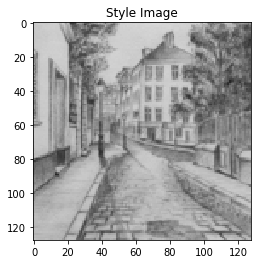

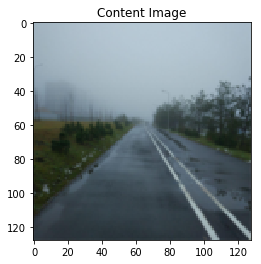

In [34]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

Напишем модуль для вычисления ошибки генерируемого изображения в отношении оригинала. При инициализации сохраним карту признаков соответствующего слоя, определим функцию ошибки. Здесь используется средне квадратичная ошибка. Так как изображение прогоняется одно, MSE будет эквивалентно $L_2^2$. Заметьте, что функция backward возвращает значение ошибки!

Здесь и далее используется функция detach(). Сеть в PyTorch представлена в виде вычислительного графа. Вычисляются при вызове модуля все вершины, которые в этом графе находятся. Функция detach() возвращает torch.Variable, вырванный из основного графа, который больше не участвует в вычислениях и не требует градиента.

In [9]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.weight = weight
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.loss = self.criterion(input * self.weight, self.target)
        self.output = input
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

Также определим модуль для подсчета матрицы Грэма

In [10]:
class GramMatrix(nn.Module):

    def forward(self, input):
        N, C, H, W = input.size()  # N=batch size(=1)
        # C=number of feature maps
        # (H,W)=dimensions of a f. map (M=H*W)

        features = input.view(N * C, H * W)  # resise F_XL into \hat F_XL

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(N * C * H * W)

Так же как и в content loss сохраним соответсвующую матрицу Грэма(в target передается уже посчитанная матрица), чтобы в будущем сравнивать с ней новые матрицы полученные на очередном прогоне. Согласно той же логике использовать будем MSE. Заметьте, что функция backward возвращает значение ошибки!

In [24]:
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight
        self.gram = GramMatrix()
        self.criterion = nn.MSELoss()

    def forward(self, input):
        self.output = input.clone()
        self.G = self.gram(input)
        self.G.mul_(self.weight)
        self.loss = self.criterion(self.G, self.target)
        return self.output

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

Выделим из претренированной VGG 19 сверточные и pooling слои

In [12]:
cnn = models.vgg19(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/ilyas/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:22<00:00, 25399821.03it/s]


Эта с виду страшная функция(заметим, что в основной код в этой функции это один и тот же фрагмент) создает на основе VGG 19 новую сеть:
1. В новую модель добавим все, что было в VGG
2. Если в переменной content_layers перечислен данный слой, то добавим после него, в виде отдельной ветви, модуль ContentLoss. От этого значения в будущем будет считаться градиент. Также сохраним ссылку на этот модуль в content_losses, понадобится для вычисления градиента.
3. Точно так же, если в переменной style_layers перечислен данный слой, то добавим после него, в виде отдельной ветви, модуль StyleLoss. От этого значения также в будущем будет считаться градиент. Также сохраним ссылку на этот модуль в style_losses, понадобится для вычисления градиента.

In [25]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, style_img, content_img,
                               style_weight=1000, content_weight=1,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    model = nn.Sequential()  # the new Sequential module network
    gram = GramMatrix()  # we need a gram module in order to compute style targets

    # move these modules to the GPU if possible:
    if use_cuda:
        model = model.cuda()
        gram = gram.cuda()

    i = 1
    for layer in list(cnn):
        if isinstance(layer, nn.Conv2d):
            name = "conv_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

        if isinstance(layer, nn.ReLU):
            name = "relu_" + str(i)
            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).clone()
                content_loss = ContentLoss(target, content_weight)
                model.add_module("content_loss_" + str(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style loss:
                target_feature = model(style_img).clone()
                target_feature_gram = gram(target_feature)
                style_loss = StyleLoss(target_feature_gram, style_weight)
                model.add_module("style_loss_" + str(i), style_loss)
                style_losses.append(style_loss)

            i += 1

        if isinstance(layer, nn.MaxPool2d):
            name = "pool_" + str(i)
            model.add_module(name, layer)  # ***

    return model, style_losses, content_losses

Инициализируем изображение, кторое будем изменять. Здесь есть два варианта:
1. Сгенерировать случайный шум.
2. Использовать изображение-оригинал

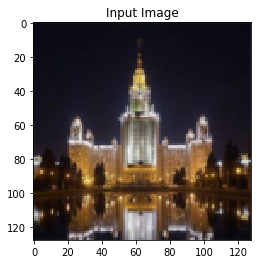

In [20]:
input_img = content_img.clone()
# if you want to use a white noise instead uncomment the below line:
# input_img = Variable(torch.randn(content_img.data.size())).type(dtype)

# add the original input image to the figure:
plt.figure()
imshow(input_img.data, title='Input Image')

При оптимизации будем использовать метод оптимизации L-BFGS. Так посоветовал автор статьи [здесь.](https://discuss.pytorch.org/t/pytorch-tutorial-for-neural-transfert-of-artistic-style/336/20?u=alexis-jacq)

In [21]:
def get_input_param_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    input_param = nn.Parameter(input_img.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

И наконец, аналогично texture synthesis, минимизируем функцию ошибки. В результате input_img будет содержать желаемое изображение с новым стилем.

In [26]:
def run_style_transfer(cnn, content_img, style_img, input_img, num_steps=300,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    # получим нашу модель и ссылки на лосс слои
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        style_img, content_img, style_weight, content_weight)
    input_param, optimizer = get_input_param_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_param.data.clamp_(0, 1)

            # очистим старые значения градиентов
            optimizer.zero_grad()
            # прогоним изображение. Здесь мы посчитаем все карты признаков, а также значения фу
            model(input_param)
            style_score = 0
            content_score = 0

            # считаем градиенты для каждого лосс слоя и достаем значение ошибки из сети
            for sl in style_losses:
                style_score += sl.backward()
            for cl in content_losses:
                content_score += cl.backward()

            # каждые 50 итераций будем проверять прогресс
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.data[0], content_score.data[0]))
                print()

            return style_score + content_score

        # сделаем оптимизационный шаг
        optimizer.step(closure)

    # a last correction...
    input_param.data.clamp_(0, 1)

    return input_param.data

И финальный шаг! Запустим процесс переноса стиля и получим долгожданное изображение в стиле картин художников.

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 0.827366 Content Loss: 5.649950

run [100]:
Style Loss : 0.812643 Content Loss: 5.558423

run [150]:
Style Loss : 0.793080 Content Loss: 5.501137

run [200]:
Style Loss : 0.785117 Content Loss: 5.455110

run [250]:
Style Loss : 0.801239 Content Loss: 5.413890

run [300]:
Style Loss : 2.477586 Content Loss: 5.421223



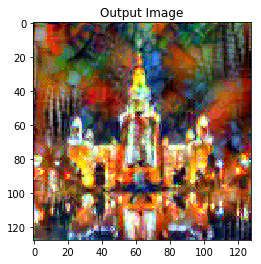

In [27]:
output = run_style_transfer(cnn, content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

Ссылки:
1. [Статья на arxiv](https://arxiv.org/abs/1508.06576)
2. [Презентация cs231n](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture12.pdf)
3. [Статья про сохранение цвета(arxiv)](https://arxiv.org/pdf/1606.05897.pdf)
4. [Статья про тренировку отдельной сети для style transfer (arxiv)](https://arxiv.org/abs/1603.08155)